# Model and Training

## Load the model

In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    !pip install dotenv
    
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# Configuration
target_size_for_training = (128, 128)
data_root = f"./raw_data"  # root directory containing 'train' and 'test' subfolders
if ON_COLAB:
    from google.colab import drive

    drive.mount(os.getenv("GOOGLE_DRIVE_CONTENT_PATH", "/content/drive"))
    data_root = os.getenv("GOOGLE_DRIVE_PATH_RESIZED", data_root)

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
model_save_dir = os.getenv("MODEL_SAVE_DIR", "./checkpoints")
os.makedirs(model_save_dir, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
IMAGE_SIZE = target_size_for_training[0]

# 2. Define the UNet diffusion model
from model import get_unet_model

model = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
).to(DEVICE)

# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print(f"Model Type: {type(model).__name__}")
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Device: {next(model.parameters()).device}")

print_model_summary(model)


# 5. Load the model checkpoint if available
def load_checkpoint(ckpt_path, model, optimizer=None, device=torch.device("cpu")):
    loaded = False
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found at {ckpt_path}, starting fresh.")
        return loaded, model, optimizer, 0

    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Rimuovi il prefisso "_orig_mod." dalle chiavi se presente
    new_state_dict = {}
    for k, v in checkpoint["model"].items():
        if k.startswith("_orig_mod."):
            new_k = k.replace("_orig_mod.", "")
            new_state_dict[new_k] = v
        else:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    model.to(device)
    loaded = True
    start_epoch = checkpoint.get("epoch", 0)
    
    if optimizer is not None and "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(f"Loaded optimizer state from checkpoint '{ckpt_path}'")
    else:
        print("Optimizer state not found in checkpoint, starting with a new optimizer.")
    
    print(f"Loaded checkpoint '{ckpt_path}' (epoch {start_epoch})")
    return loaded, model, optimizer, start_epoch


WEIGHT_DECAY = 1e-5  # weight decay for regularization
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Load the model checkpoint
ckpt = "checkpoints/ddim_unet_epoch20.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    ckpt, model, optimizer, device=DEVICE
)
model.eval()
if isModelLoadedFromCheckpoint:
    print(f"Model {ckpt.split('/')[-1]} loaded and moved to {DEVICE}, starting from epoch {start_epoch}.")
else:
    print(f"Model {ckpt.split('/')[-1]} not found. Starting from scratch, loaded on {DEVICE}, starting from epoch {start_epoch}.")

train_losses, val_losses = [], []

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
No checkpoint found at checkpoints/ddim_unet_epoch20.pth, starting fresh.
Model ddim_unet_epoch20.pth not found. Starting from scratch, loaded on cuda, starting from epoch 0.


## Training and validation

In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import NUM_TRAIN_TIMESTEPS, sample_images, AugmentedDataset, save_checkpoint

# Config
BATCH_SIZE = 16
NUM_EPOCHS = 20
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_dataset = AugmentedDataset(root_dir=train_dir, image_size=IMAGE_SIZE)
test_dataset = AugmentedDataset(root_dir=test_dir, image_size=IMAGE_SIZE)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# Scheduler and Model Setup
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=True,
)
ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

        # if step % (len(train_loader) // 3) == 0:
        #     print(f"Reached step {step} of epoch {epoch}. Saving sample image and weights.")
        #     sample_images(
        #         output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}_step_{step}.png",
        #         num_steps=NUM_TRAIN_TIMESTEPS,
        #         DEVICE=DEVICE,
        #         IMAGE_SIZE=IMAGE_SIZE,
        #         model=model,
        #         ddim_scheduler=ddim_scheduler,
        #     )
        #     ckpt_path = os.path.join(
        #         model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}_step{step}.pth"
        #     )
        #     save_checkpoint(
        #         model=model,
        #         optimizer=optimizer,
        #         epoch=epoch + start_epoch,
        #         path=ckpt_path,
        #     )

    sample_images(
        output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 13224
Validation samples: 1308
Training on cuda | Batch Size: 16 | Epochs: 20 | Starting at epoch 0
[Epoch 1/20 | Step 50/827] Train Loss: 0.082664
[Epoch 1/20 | Step 100/827] Train Loss: 0.049215
[Epoch 1/20 | Step 150/827] Train Loss: 0.036906
[Epoch 1/20 | Step 200/827] Train Loss: 0.065360
[Epoch 1/20 | Step 250/827] Train Loss: 0.020187
[Epoch 1/20 | Step 300/827] Train Loss: 0.011440
[Epoch 1/20 | Step 350/827] Train Loss: 0.026675
[Epoch 1/20 | Step 400/827] Train Loss: 0.021608
[Epoch 1/20 | Step 450/827] Train Loss: 0.019178
[Epoch 1/20 | Step 500/827] Train Loss: 0.009964
[Epoch 1/20 | Step 550/827] Train Loss: 0.009963
[Epoch 1/20 | Step 600/827] Train Loss: 0.021405
[Epoch 1/20 | Step 650/827] Train Loss: 0.014233
[Epoch 1/20 | Step 700/827] Train Loss: 0.017499
[Epoch 1/20 | Step 750/827] Train Loss: 0.015954
[Epoch 1/20 | Step 800/827] Train Loss: 0.015614
[Epoch 1/20 | 

Sampling DDIM: 100%|██████████| 1000/1000 [00:25<00:00, 38.50it/s]


Sample saved to ./checkpoints/epoch_1.png
Epoch 1 complete. Avg Train Loss: 0.042238
Epoch 1 complete. Avg Validation Loss: 0.018958
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch1.pth
[Epoch 2/20 | Step 50/827] Train Loss: 0.012894
[Epoch 2/20 | Step 100/827] Train Loss: 0.026749
[Epoch 2/20 | Step 150/827] Train Loss: 0.010029
[Epoch 2/20 | Step 200/827] Train Loss: 0.037270
[Epoch 2/20 | Step 250/827] Train Loss: 0.007820
[Epoch 2/20 | Step 300/827] Train Loss: 0.025160
[Epoch 2/20 | Step 350/827] Train Loss: 0.008646
[Epoch 2/20 | Step 400/827] Train Loss: 0.014851
[Epoch 2/20 | Step 450/827] Train Loss: 0.004761
[Epoch 2/20 | Step 500/827] Train Loss: 0.005666
[Epoch 2/20 | Step 550/827] Train Loss: 0.011725
[Epoch 2/20 | Step 600/827] Train Loss: 0.009505
[Epoch 2/20 | Step 650/827] Train Loss: 0.010013
[Epoch 2/20 | Step 700/827] Train Loss: 0.006606
[Epoch 2/20 | Step 750/827] Train Loss: 0.022124
[Epoch 2/20 | Step 800/827] Train Loss: 0.013732
[Epoch 2/20 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.79it/s]

Sample saved to ./checkpoints/epoch_2.png
Epoch 2 complete. Avg Train Loss: 0.019018


Epoch 2 complete. Avg Validation Loss: 0.013242
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch2.pth
[Epoch 3/20 | Step 50/827] Train Loss: 0.009694
[Epoch 3/20 | Step 100/827] Train Loss: 0.011990
[Epoch 3/20 | Step 150/827] Train Loss: 0.007437
[Epoch 3/20 | Step 200/827] Train Loss: 0.008426
[Epoch 3/20 | Step 250/827] Train Loss: 0.032388
[Epoch 3/20 | Step 300/827] Train Loss: 0.013029
[Epoch 3/20 | Step 350/827] Train Loss: 0.020675
[Epoch 3/20 | Step 400/827] Train Loss: 0.019848
[Epoch 3/20 | Step 450/827] Train Loss: 0.010014
[Epoch 3/20 | Step 500/827] Train Loss: 0.011051
[Epoch 3/20 | Step 550/827] Train Loss: 0.009351
[Epoch 3/20 | Step 600/827] Train Loss: 0.013578
[Epoch 3/20 | Step 650/827] Train Loss: 0.016015
[Epoch 3/20 | Step 700/827] Train Loss: 0.024027
[Epoch 3/20 | Step 750/827] Train Loss: 0.003643
[Epoch 3/20 | Step 800/827] Train Loss: 0.030405
[Epoch 3/20 | Step 827/827] Train Loss: 0.038935


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]

Sample saved to ./checkpoints/epoch_3.png
Epoch 3 complete. Avg Train Loss: 0.015564


Epoch 3 complete. Avg Validation Loss: 0.012445
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch3.pth
[Epoch 4/20 | Step 50/827] Train Loss: 0.021104
[Epoch 4/20 | Step 100/827] Train Loss: 0.007211
[Epoch 4/20 | Step 150/827] Train Loss: 0.006402
[Epoch 4/20 | Step 200/827] Train Loss: 0.024770
[Epoch 4/20 | Step 250/827] Train Loss: 0.008316
[Epoch 4/20 | Step 300/827] Train Loss: 0.014429
[Epoch 4/20 | Step 350/827] Train Loss: 0.011292
[Epoch 4/20 | Step 400/827] Train Loss: 0.013928
[Epoch 4/20 | Step 450/827] Train Loss: 0.034566
[Epoch 4/20 | Step 500/827] Train Loss: 0.004549
[Epoch 4/20 | Step 550/827] Train Loss: 0.017933
[Epoch 4/20 | Step 600/827] Train Loss: 0.006646
[Epoch 4/20 | Step 650/827] Train Loss: 0.014995
[Epoch 4/20 | Step 700/827] Train Loss: 0.015620
[Epoch 4/20 | Step 750/827] Train Loss: 0.015866
[Epoch 4/20 | Step 800/827] Train Loss: 0.019877
[Epoch 4/20 | Step 827/827] Train Loss: 0.005848


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.87it/s]

Sample saved to ./checkpoints/epoch_4.png
Epoch 4 complete. Avg Train Loss: 0.013285


Epoch 4 complete. Avg Validation Loss: 0.011155
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch4.pth
[Epoch 5/20 | Step 50/827] Train Loss: 0.005402
[Epoch 5/20 | Step 100/827] Train Loss: 0.009042
[Epoch 5/20 | Step 150/827] Train Loss: 0.006908
[Epoch 5/20 | Step 200/827] Train Loss: 0.008107
[Epoch 5/20 | Step 250/827] Train Loss: 0.013071
[Epoch 5/20 | Step 300/827] Train Loss: 0.025280
[Epoch 5/20 | Step 350/827] Train Loss: 0.004452
[Epoch 5/20 | Step 400/827] Train Loss: 0.018216
[Epoch 5/20 | Step 450/827] Train Loss: 0.008324
[Epoch 5/20 | Step 500/827] Train Loss: 0.004161
[Epoch 5/20 | Step 550/827] Train Loss: 0.010816
[Epoch 5/20 | Step 600/827] Train Loss: 0.008892
[Epoch 5/20 | Step 650/827] Train Loss: 0.007633
[Epoch 5/20 | Step 700/827] Train Loss: 0.009009
[Epoch 5/20 | Step 750/827] Train Loss: 0.014665
[Epoch 5/20 | Step 800/827] Train Loss: 0.003885
[Epoch 5/20 | Step 827/827] Train Loss: 0.001757


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.81it/s]

Sample saved to ./checkpoints/epoch_5.png
Epoch 5 complete. Avg Train Loss: 0.012207


Epoch 5 complete. Avg Validation Loss: 0.010253
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch5.pth
[Epoch 6/20 | Step 50/827] Train Loss: 0.004069
[Epoch 6/20 | Step 100/827] Train Loss: 0.005937
[Epoch 6/20 | Step 150/827] Train Loss: 0.004314
[Epoch 6/20 | Step 200/827] Train Loss: 0.013580
[Epoch 6/20 | Step 250/827] Train Loss: 0.007517
[Epoch 6/20 | Step 300/827] Train Loss: 0.010287
[Epoch 6/20 | Step 350/827] Train Loss: 0.013958
[Epoch 6/20 | Step 400/827] Train Loss: 0.020994
[Epoch 6/20 | Step 450/827] Train Loss: 0.007265
[Epoch 6/20 | Step 500/827] Train Loss: 0.039884
[Epoch 6/20 | Step 550/827] Train Loss: 0.024341
[Epoch 6/20 | Step 600/827] Train Loss: 0.003701
[Epoch 6/20 | Step 650/827] Train Loss: 0.003603
[Epoch 6/20 | Step 700/827] Train Loss: 0.005286
[Epoch 6/20 | Step 750/827] Train Loss: 0.005011
[Epoch 6/20 | Step 800/827] Train Loss: 0.020650
[Epoch 6/20 | Step 827/827] Train Loss: 0.004474


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.72it/s]

Sample saved to ./checkpoints/epoch_6.png
Epoch 6 complete. Avg Train Loss: 0.011824


Epoch 6 complete. Avg Validation Loss: 0.011132
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch6.pth
[Epoch 7/20 | Step 50/827] Train Loss: 0.008719
[Epoch 7/20 | Step 100/827] Train Loss: 0.010646
[Epoch 7/20 | Step 150/827] Train Loss: 0.010648
[Epoch 7/20 | Step 200/827] Train Loss: 0.016879
[Epoch 7/20 | Step 250/827] Train Loss: 0.016308
[Epoch 7/20 | Step 300/827] Train Loss: 0.008307
[Epoch 7/20 | Step 350/827] Train Loss: 0.009800
[Epoch 7/20 | Step 400/827] Train Loss: 0.004266
[Epoch 7/20 | Step 450/827] Train Loss: 0.026203
[Epoch 7/20 | Step 500/827] Train Loss: 0.003668
[Epoch 7/20 | Step 550/827] Train Loss: 0.008995
[Epoch 7/20 | Step 600/827] Train Loss: 0.003437
[Epoch 7/20 | Step 650/827] Train Loss: 0.016330
[Epoch 7/20 | Step 700/827] Train Loss: 0.015423
[Epoch 7/20 | Step 750/827] Train Loss: 0.012176
[Epoch 7/20 | Step 800/827] Train Loss: 0.019837
[Epoch 7/20 | Step 827/827] Train Loss: 0.019243


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.22it/s]

Sample saved to ./checkpoints/epoch_7.png
Epoch 7 complete. Avg Train Loss: 0.011484


Epoch 7 complete. Avg Validation Loss: 0.009429
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch7.pth
[Epoch 8/20 | Step 50/827] Train Loss: 0.006897
[Epoch 8/20 | Step 100/827] Train Loss: 0.011356
[Epoch 8/20 | Step 150/827] Train Loss: 0.006537
[Epoch 8/20 | Step 200/827] Train Loss: 0.005877
[Epoch 8/20 | Step 250/827] Train Loss: 0.010937
[Epoch 8/20 | Step 300/827] Train Loss: 0.009622
[Epoch 8/20 | Step 350/827] Train Loss: 0.019017
[Epoch 8/20 | Step 400/827] Train Loss: 0.032326
[Epoch 8/20 | Step 450/827] Train Loss: 0.006636
[Epoch 8/20 | Step 500/827] Train Loss: 0.020075
[Epoch 8/20 | Step 550/827] Train Loss: 0.007270
[Epoch 8/20 | Step 600/827] Train Loss: 0.004242
[Epoch 8/20 | Step 650/827] Train Loss: 0.009397
[Epoch 8/20 | Step 700/827] Train Loss: 0.025200
[Epoch 8/20 | Step 750/827] Train Loss: 0.009285
[Epoch 8/20 | Step 800/827] Train Loss: 0.006006
[Epoch 8/20 | Step 827/827] Train Loss: 0.003308


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.95it/s]

Sample saved to ./checkpoints/epoch_8.png
Epoch 8 complete. Avg Train Loss: 0.011097


Epoch 8 complete. Avg Validation Loss: 0.009107
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch8.pth
[Epoch 9/20 | Step 50/827] Train Loss: 0.007341
[Epoch 9/20 | Step 100/827] Train Loss: 0.009637
[Epoch 9/20 | Step 150/827] Train Loss: 0.008482
[Epoch 9/20 | Step 200/827] Train Loss: 0.004111
[Epoch 9/20 | Step 250/827] Train Loss: 0.011934
[Epoch 9/20 | Step 300/827] Train Loss: 0.029828
[Epoch 9/20 | Step 350/827] Train Loss: 0.007899
[Epoch 9/20 | Step 400/827] Train Loss: 0.029553
[Epoch 9/20 | Step 450/827] Train Loss: 0.011289
[Epoch 9/20 | Step 500/827] Train Loss: 0.012659
[Epoch 9/20 | Step 550/827] Train Loss: 0.012132
[Epoch 9/20 | Step 600/827] Train Loss: 0.003687
[Epoch 9/20 | Step 650/827] Train Loss: 0.004290
[Epoch 9/20 | Step 700/827] Train Loss: 0.006856
[Epoch 9/20 | Step 750/827] Train Loss: 0.013387
[Epoch 9/20 | Step 800/827] Train Loss: 0.010420
[Epoch 9/20 | Step 827/827] Train Loss: 0.005057


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.92it/s]

Sample saved to ./checkpoints/epoch_9.png
Epoch 9 complete. Avg Train Loss: 0.010691


Epoch 9 complete. Avg Validation Loss: 0.010188
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch9.pth
[Epoch 10/20 | Step 50/827] Train Loss: 0.006246
[Epoch 10/20 | Step 100/827] Train Loss: 0.009287
[Epoch 10/20 | Step 150/827] Train Loss: 0.012432
[Epoch 10/20 | Step 200/827] Train Loss: 0.013507
[Epoch 10/20 | Step 250/827] Train Loss: 0.005701
[Epoch 10/20 | Step 300/827] Train Loss: 0.017988
[Epoch 10/20 | Step 350/827] Train Loss: 0.008355
[Epoch 10/20 | Step 400/827] Train Loss: 0.006686
[Epoch 10/20 | Step 450/827] Train Loss: 0.003559
[Epoch 10/20 | Step 500/827] Train Loss: 0.006754
[Epoch 10/20 | Step 550/827] Train Loss: 0.007186
[Epoch 10/20 | Step 600/827] Train Loss: 0.003727
[Epoch 10/20 | Step 650/827] Train Loss: 0.011514
[Epoch 10/20 | Step 700/827] Train Loss: 0.018115
[Epoch 10/20 | Step 750/827] Train Loss: 0.008522
[Epoch 10/20 | Step 800/827] Train Loss: 0.004706
[Epoch 10/20 | Step 827/827] Train Loss: 0.007673


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s]

Sample saved to ./checkpoints/epoch_10.png
Epoch 10 complete. Avg Train Loss: 0.010599


Epoch 10 complete. Avg Validation Loss: 0.010562
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch10.pth
[Epoch 11/20 | Step 50/827] Train Loss: 0.008187
[Epoch 11/20 | Step 100/827] Train Loss: 0.004895
[Epoch 11/20 | Step 150/827] Train Loss: 0.022340
[Epoch 11/20 | Step 200/827] Train Loss: 0.014397
[Epoch 11/20 | Step 250/827] Train Loss: 0.027375
[Epoch 11/20 | Step 300/827] Train Loss: 0.004056
[Epoch 11/20 | Step 350/827] Train Loss: 0.011131
[Epoch 11/20 | Step 400/827] Train Loss: 0.020124
[Epoch 11/20 | Step 450/827] Train Loss: 0.004263
[Epoch 11/20 | Step 500/827] Train Loss: 0.042063
[Epoch 11/20 | Step 550/827] Train Loss: 0.003190
[Epoch 11/20 | Step 600/827] Train Loss: 0.004789
[Epoch 11/20 | Step 650/827] Train Loss: 0.004248
[Epoch 11/20 | Step 700/827] Train Loss: 0.008343
[Epoch 11/20 | Step 750/827] Train Loss: 0.025637
[Epoch 11/20 | Step 800/827] Train Loss: 0.006158
[Epoch 11/20 | Step 827/827] Train Loss: 0.003940


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.81it/s]

Sample saved to ./checkpoints/epoch_11.png
Epoch 11 complete. Avg Train Loss: 0.010456


Epoch 11 complete. Avg Validation Loss: 0.009624
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch11.pth
[Epoch 12/20 | Step 50/827] Train Loss: 0.010136
[Epoch 12/20 | Step 100/827] Train Loss: 0.004061
[Epoch 12/20 | Step 150/827] Train Loss: 0.006080
[Epoch 12/20 | Step 200/827] Train Loss: 0.004566
[Epoch 12/20 | Step 250/827] Train Loss: 0.005617
[Epoch 12/20 | Step 300/827] Train Loss: 0.012947
[Epoch 12/20 | Step 350/827] Train Loss: 0.005668
[Epoch 12/20 | Step 400/827] Train Loss: 0.014670
[Epoch 12/20 | Step 450/827] Train Loss: 0.004341
[Epoch 12/20 | Step 500/827] Train Loss: 0.012800
[Epoch 12/20 | Step 550/827] Train Loss: 0.010532
[Epoch 12/20 | Step 600/827] Train Loss: 0.002567
[Epoch 12/20 | Step 650/827] Train Loss: 0.028495
[Epoch 12/20 | Step 700/827] Train Loss: 0.014827
[Epoch 12/20 | Step 750/827] Train Loss: 0.007514
[Epoch 12/20 | Step 800/827] Train Loss: 0.016324
[Epoch 12/20 | Step 827/827] Train Loss: 0.006805


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.84it/s]

Sample saved to ./checkpoints/epoch_12.png
Epoch 12 complete. Avg Train Loss: 0.010193


Epoch 12 complete. Avg Validation Loss: 0.010493
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch12.pth
[Epoch 13/20 | Step 50/827] Train Loss: 0.011034
[Epoch 13/20 | Step 100/827] Train Loss: 0.006143
[Epoch 13/20 | Step 150/827] Train Loss: 0.006422
[Epoch 13/20 | Step 200/827] Train Loss: 0.002182
[Epoch 13/20 | Step 250/827] Train Loss: 0.004559
[Epoch 13/20 | Step 300/827] Train Loss: 0.018076
[Epoch 13/20 | Step 350/827] Train Loss: 0.010841
[Epoch 13/20 | Step 400/827] Train Loss: 0.002192
[Epoch 13/20 | Step 450/827] Train Loss: 0.021491
[Epoch 13/20 | Step 500/827] Train Loss: 0.007633
[Epoch 13/20 | Step 550/827] Train Loss: 0.007064
[Epoch 13/20 | Step 600/827] Train Loss: 0.001266
[Epoch 13/20 | Step 650/827] Train Loss: 0.008719
[Epoch 13/20 | Step 700/827] Train Loss: 0.011698
[Epoch 13/20 | Step 750/827] Train Loss: 0.005211
[Epoch 13/20 | Step 800/827] Train Loss: 0.010002
[Epoch 13/20 | Step 827/827] Train Loss: 0.007552


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.92it/s]

Sample saved to ./checkpoints/epoch_13.png
Epoch 13 complete. Avg Train Loss: 0.010061


Epoch 13 complete. Avg Validation Loss: 0.011031
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch13.pth
[Epoch 14/20 | Step 50/827] Train Loss: 0.009137
[Epoch 14/20 | Step 100/827] Train Loss: 0.003703
[Epoch 14/20 | Step 150/827] Train Loss: 0.031374
[Epoch 14/20 | Step 200/827] Train Loss: 0.005931
[Epoch 14/20 | Step 250/827] Train Loss: 0.005715
[Epoch 14/20 | Step 300/827] Train Loss: 0.010104
[Epoch 14/20 | Step 350/827] Train Loss: 0.015796
[Epoch 14/20 | Step 400/827] Train Loss: 0.002513
[Epoch 14/20 | Step 450/827] Train Loss: 0.013850
[Epoch 14/20 | Step 500/827] Train Loss: 0.003121
[Epoch 14/20 | Step 550/827] Train Loss: 0.014956
[Epoch 14/20 | Step 600/827] Train Loss: 0.024809
[Epoch 14/20 | Step 650/827] Train Loss: 0.020905
[Epoch 14/20 | Step 700/827] Train Loss: 0.011395
[Epoch 14/20 | Step 750/827] Train Loss: 0.022189
[Epoch 14/20 | Step 800/827] Train Loss: 0.003905
[Epoch 14/20 | Step 827/827] Train Loss: 0.019466


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]


Sample saved to ./checkpoints/epoch_14.png
Epoch 14 complete. Avg Train Loss: 0.009961
Epoch 14 complete. Avg Validation Loss: 0.009317
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch14.pth
[Epoch 15/20 | Step 50/827] Train Loss: 0.005367
[Epoch 15/20 | Step 100/827] Train Loss: 0.004666
[Epoch 15/20 | Step 150/827] Train Loss: 0.017730
[Epoch 15/20 | Step 200/827] Train Loss: 0.009182
[Epoch 15/20 | Step 250/827] Train Loss: 0.005974
[Epoch 15/20 | Step 300/827] Train Loss: 0.005568
[Epoch 15/20 | Step 350/827] Train Loss: 0.006464
[Epoch 15/20 | Step 400/827] Train Loss: 0.007681
[Epoch 15/20 | Step 450/827] Train Loss: 0.012008
[Epoch 15/20 | Step 500/827] Train Loss: 0.005723
[Epoch 15/20 | Step 550/827] Train Loss: 0.008028
[Epoch 15/20 | Step 600/827] Train Loss: 0.001888
[Epoch 15/20 | Step 650/827] Train Loss: 0.020714
[Epoch 15/20 | Step 700/827] Train Loss: 0.003027
[Epoch 15/20 | Step 750/827] Train Loss: 0.002185
[Epoch 15/20 | Step 800/827] Train Loss: 0.015282
[Epoch

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.95it/s]

Sample saved to ./checkpoints/epoch_15.png
Epoch 15 complete. Avg Train Loss: 0.009705


Epoch 15 complete. Avg Validation Loss: 0.009336
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch15.pth
[Epoch 16/20 | Step 50/827] Train Loss: 0.007887
[Epoch 16/20 | Step 100/827] Train Loss: 0.010462
[Epoch 16/20 | Step 150/827] Train Loss: 0.005234
[Epoch 16/20 | Step 200/827] Train Loss: 0.006494
[Epoch 16/20 | Step 250/827] Train Loss: 0.003410
[Epoch 16/20 | Step 300/827] Train Loss: 0.019332
[Epoch 16/20 | Step 350/827] Train Loss: 0.007608
[Epoch 16/20 | Step 400/827] Train Loss: 0.006393
[Epoch 16/20 | Step 450/827] Train Loss: 0.009861
[Epoch 16/20 | Step 500/827] Train Loss: 0.014572
[Epoch 16/20 | Step 550/827] Train Loss: 0.010761
[Epoch 16/20 | Step 600/827] Train Loss: 0.004169
[Epoch 16/20 | Step 650/827] Train Loss: 0.003811
[Epoch 16/20 | Step 700/827] Train Loss: 0.003032
[Epoch 16/20 | Step 750/827] Train Loss: 0.011226
[Epoch 16/20 | Step 800/827] Train Loss: 0.004435
[Epoch 16/20 | Step 827/827] Train Loss: 0.013240


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.39it/s]

Sample saved to ./checkpoints/epoch_16.png
Epoch 16 complete. Avg Train Loss: 0.009732


Epoch 16 complete. Avg Validation Loss: 0.009744
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch16.pth
[Epoch 17/20 | Step 50/827] Train Loss: 0.006662
[Epoch 17/20 | Step 100/827] Train Loss: 0.010860
[Epoch 17/20 | Step 150/827] Train Loss: 0.006208
[Epoch 17/20 | Step 200/827] Train Loss: 0.002804
[Epoch 17/20 | Step 250/827] Train Loss: 0.002402
[Epoch 17/20 | Step 300/827] Train Loss: 0.011271
[Epoch 17/20 | Step 350/827] Train Loss: 0.009262
[Epoch 17/20 | Step 400/827] Train Loss: 0.005382
[Epoch 17/20 | Step 450/827] Train Loss: 0.005148
[Epoch 17/20 | Step 500/827] Train Loss: 0.009838
[Epoch 17/20 | Step 550/827] Train Loss: 0.004526
[Epoch 17/20 | Step 600/827] Train Loss: 0.003865
[Epoch 17/20 | Step 650/827] Train Loss: 0.031964
[Epoch 17/20 | Step 700/827] Train Loss: 0.004636
[Epoch 17/20 | Step 750/827] Train Loss: 0.012295
[Epoch 17/20 | Step 800/827] Train Loss: 0.008232
[Epoch 17/20 | Step 827/827] Train Loss: 0.002533


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.91it/s]

Sample saved to ./checkpoints/epoch_17.png
Epoch 17 complete. Avg Train Loss: 0.009557


Epoch 17 complete. Avg Validation Loss: 0.009840
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch17.pth
[Epoch 18/20 | Step 50/827] Train Loss: 0.010335
[Epoch 18/20 | Step 100/827] Train Loss: 0.011117
[Epoch 18/20 | Step 150/827] Train Loss: 0.015539
[Epoch 18/20 | Step 200/827] Train Loss: 0.005580
[Epoch 18/20 | Step 250/827] Train Loss: 0.004195
[Epoch 18/20 | Step 300/827] Train Loss: 0.004296
[Epoch 18/20 | Step 350/827] Train Loss: 0.004814
[Epoch 18/20 | Step 400/827] Train Loss: 0.006405
[Epoch 18/20 | Step 450/827] Train Loss: 0.010528
[Epoch 18/20 | Step 500/827] Train Loss: 0.006138
[Epoch 18/20 | Step 550/827] Train Loss: 0.004768
[Epoch 18/20 | Step 600/827] Train Loss: 0.010230
[Epoch 18/20 | Step 650/827] Train Loss: 0.003156
[Epoch 18/20 | Step 700/827] Train Loss: 0.004320
[Epoch 18/20 | Step 750/827] Train Loss: 0.005122
[Epoch 18/20 | Step 800/827] Train Loss: 0.004945
[Epoch 18/20 | Step 827/827] Train Loss: 0.019743


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.84it/s]

Sample saved to ./checkpoints/epoch_18.png
Epoch 18 complete. Avg Train Loss: 0.009066


Epoch 18 complete. Avg Validation Loss: 0.010212
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch18.pth
[Epoch 19/20 | Step 50/827] Train Loss: 0.010425
[Epoch 19/20 | Step 100/827] Train Loss: 0.002671
[Epoch 19/20 | Step 150/827] Train Loss: 0.008159
[Epoch 19/20 | Step 200/827] Train Loss: 0.002714
[Epoch 19/20 | Step 250/827] Train Loss: 0.002956
[Epoch 19/20 | Step 300/827] Train Loss: 0.002509
[Epoch 19/20 | Step 350/827] Train Loss: 0.009741
[Epoch 19/20 | Step 400/827] Train Loss: 0.006333
[Epoch 19/20 | Step 450/827] Train Loss: 0.023014
[Epoch 19/20 | Step 500/827] Train Loss: 0.004999
[Epoch 19/20 | Step 550/827] Train Loss: 0.005769
[Epoch 19/20 | Step 600/827] Train Loss: 0.026428
[Epoch 19/20 | Step 650/827] Train Loss: 0.004364
[Epoch 19/20 | Step 700/827] Train Loss: 0.009958
[Epoch 19/20 | Step 750/827] Train Loss: 0.006600
[Epoch 19/20 | Step 800/827] Train Loss: 0.011628
[Epoch 19/20 | Step 827/827] Train Loss: 0.009943


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.74it/s]

Sample saved to ./checkpoints/epoch_19.png
Epoch 19 complete. Avg Train Loss: 0.010338


Epoch 19 complete. Avg Validation Loss: 0.011198
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch19.pth
[Epoch 20/20 | Step 50/827] Train Loss: 0.005325
[Epoch 20/20 | Step 100/827] Train Loss: 0.003205
[Epoch 20/20 | Step 150/827] Train Loss: 0.004463
[Epoch 20/20 | Step 200/827] Train Loss: 0.006886
[Epoch 20/20 | Step 250/827] Train Loss: 0.006051
[Epoch 20/20 | Step 300/827] Train Loss: 0.004635
[Epoch 20/20 | Step 350/827] Train Loss: 0.034644
[Epoch 20/20 | Step 400/827] Train Loss: 0.004480
[Epoch 20/20 | Step 450/827] Train Loss: 0.006313
[Epoch 20/20 | Step 500/827] Train Loss: 0.012545
[Epoch 20/20 | Step 550/827] Train Loss: 0.002261
[Epoch 20/20 | Step 600/827] Train Loss: 0.004731
[Epoch 20/20 | Step 650/827] Train Loss: 0.015650
[Epoch 20/20 | Step 700/827] Train Loss: 0.007762
[Epoch 20/20 | Step 750/827] Train Loss: 0.037866
[Epoch 20/20 | Step 800/827] Train Loss: 0.004439
[Epoch 20/20 | Step 827/827] Train Loss: 0.001752


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.83it/s]

Sample saved to ./checkpoints/epoch_20.png
Epoch 20 complete. Avg Train Loss: 0.009337


Epoch 20 complete. Avg Validation Loss: 0.010129
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch20.pth


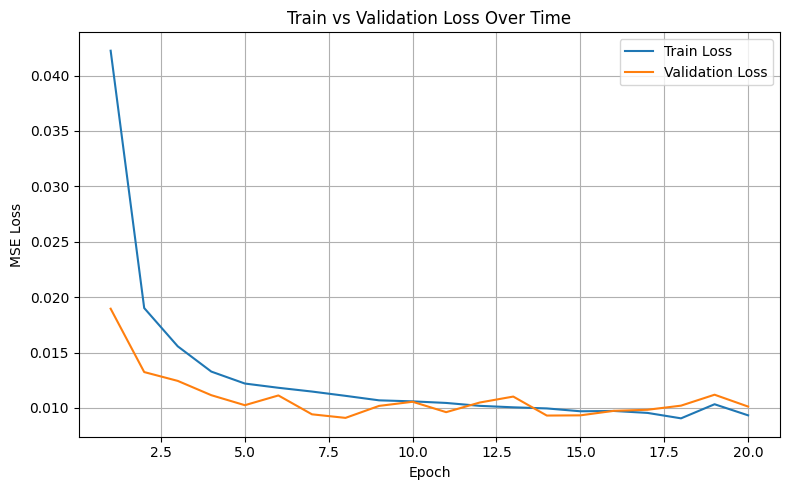

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the loss history file
history_file = os.path.join(model_save_dir, "loss_history.txt")

# Load existing history if it exists
all_train_losses = []
all_val_losses = []

if os.path.exists(history_file):
    with open(history_file, "r") as f:
        lines = f.readlines()[1:]  # Skip header
        for line in lines:
            _, train_loss, val_loss = line.strip().split("\t")
            all_train_losses.append(float(train_loss))
            all_val_losses.append(float(val_loss))

# Append current session's losses
all_train_losses.extend(train_losses)
all_val_losses.extend(val_losses)

# Save updated history
with open(history_file, "w") as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")
    for i, (tr, vl) in enumerate(zip(all_train_losses, all_val_losses), 1):
        f.write(f"{i}\t{tr:.6f}\t{vl:.6f}\n")

# Plot full loss history
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train Loss")
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
from diffusers import DDPMScheduler, DDIMScheduler
from tqdm import tqdm
from utils import sample_images

# Imposta il numero di step di inferenza per DDIM (uguale a NUM_TRAIN_TIMESTEPS di default)
# 6. Sampling example with DDIM
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=True,
)

ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)


# Sample images
for i in range(10):
    sample_images(
        output_path=f"result/ddim_sample_epoch{epoch + start_epoch}_{i}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.72it/s]


Sample saved to result/ddim_sample_epoch20_0.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.86it/s]


Sample saved to result/ddim_sample_epoch20_1.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.59it/s]


Sample saved to result/ddim_sample_epoch20_2.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.60it/s]


Sample saved to result/ddim_sample_epoch20_3.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.58it/s]


Sample saved to result/ddim_sample_epoch20_4.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.24it/s]


Sample saved to result/ddim_sample_epoch20_5.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.26it/s]


Sample saved to result/ddim_sample_epoch20_6.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.94it/s]


Sample saved to result/ddim_sample_epoch20_7.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.74it/s]


Sample saved to result/ddim_sample_epoch20_8.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.64it/s]

Sample saved to result/ddim_sample_epoch20_9.png
